# For an analysis competition...
What to predict?
- age ... too few nans (prediction may be meaningless...)
- cancellation of premium membership

# Libraries

In [3]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage, plot_target
from categorical_encoder import label_encoding
from feature_converter import categorize_features
from adversarial_validaton import AdversarialValidation
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer

# custom modeling functions
sys.path.append(mypath + '/models/') 
from base_models import BaseModel
from lgb_models import LgbModel
from catb_models import CatbModel

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

libraries imported


# Load data

In [4]:
!ls

EDA.ipynb             Modeling_laputa.ipynb models
EDA_houseprice.ipynb  cls_models            reg_models
EDA_laputa.ipynb      code
EDA_titanic.ipynb     inputs


In [5]:
# check path
datapath = "inputs/"
datapath = "/Volumes/sec/anemos-poc-large-sec/users/kakawagu/data/laputa_comp"
files = os.listdir(datapath)
print(files)

['laputa_age.csv', 'laputa.csv', 'laputa_noage.csv']


In [6]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/laputa_age.csv', index_col=0)
test = pd.read_csv(datapath + '/laputa_noage.csv', index_col=0)

time1 = time.time()
print(time1 - time0, " seconds to load data")

3.204425096511841  seconds to load data


In [7]:
# check train
print(train.shape)
train.head()

(10000, 815)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0012356A351358D871,1,NaN,20190428,20190501.0,20191201,49,8,31,8,...,NaN,0.067452,NaN,NaN,NaN,NaN,0.05795,NaN,NaN,NaN
1,00148ED6D273F9B2DD,1,NaN,20160925,20160929.0,20191127,45,39,166,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0003BCA15E2EFB1955,1,NaN,20160508,20160513.0,20191130,23,43,186,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000A7D82545E783A8E,1,NaN,20160612,20160615.0,20191201,42,42,181,42,...,NaN,0.035689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000A84CEFE8881F2AA,1,NaN,20191020,20191022.0,20191201,58,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# check test
print(test.shape)
test.head()

(10000, 815)


,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,0013CB9311A8ADDE2C,0,NaN,20170528,20170530.0,20191201,NaN,31,131,31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039645C6FA1C0ABC,0,NaN,20190224,20190301.0,20191201,NaN,10,40,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00151F8DE7DFD5D93C,0,NaN,20190623,20190627.0,20191201,NaN,6,23,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000C53CB2E2051E6A2,0,NaN,20190616,20190620.0,20191201,NaN,6,24,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0012E6705A765C2DA2,0,NaN,20190922,20190923.0,20191201,NaN,3,10,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Columns: 815 entries, y_id_hex to 99_yup_user_daily_score_2_interest_know_well_construction
dtypes: bool(4), float64(706), int64(19), object(86)
memory usage: 62.0+ MB


In [10]:
train.dtypes

y_id_hex                                                                object
1_y_id_master_gender                                                     int64
1_y_id_master_birthday                                                 float64
1_y_id_master_registration_date                                          int64
1_y_id_master_first_update                                             float64
1_y_id_master_last_update                                                int64
1_y_id_master_age                                                        int64
1_y_id_master_registration_month                                         int64
1_y_id_master_registration_week                                          int64
2_user_profile_master_commerce_registration_month                        int64
2_user_profile_master_commerce_gender                                    int64
2_user_profile_master_commerce_age                                       int64
2_user_profile_master_commerce_generation1          

# Target

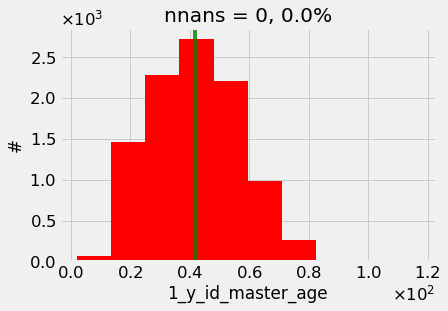

In [11]:
# hist
target = "1_y_id_master_age"
plot_target(train, target, objective="regression")

In [12]:
# roughly categorize features
features, dense_features, cat_features = categorize_features(train, target, cat_threshold=20)

There are 814 features.
There are 466 dense features.
There are 348 categorical features.


# Dense features

In [13]:
vd = DenseVisualizer(train=train, test=test, features=dense_features, target=target)
chkd = vd.column_checker()

feature name = 1_y_id_master_registration_date
feature name = 1_y_id_master_first_update
feature name = 1_y_id_master_last_update
feature name = 1_y_id_master_registration_month
feature name = 1_y_id_master_registration_week
feature name = 2_user_profile_master_commerce_registration_month
feature name = 2_user_profile_master_commerce_age
feature name = 2_user_profile_master_commerce_preimum_registration_month
feature name = 2_user_profile_master_commerce_wallet_registration_month
feature name = 2_user_profile_master_commerce_shopping_order_count
feature name = 2_user_profile_master_commerce_shopping_avg_total_price
feature name = 2_user_profile_master_commerce_shopping_avg_order_day
feature name = 2_user_profile_master_commerce_shopping_last_order_day
feature name = 2_user_profile_master_commerce_auction_won_count
feature name = 2_user_profile_master_commerce_auction_avg_won_price
feature name = 2_user_profile_master_commerce_auction_avg_won_day
feature name = 2_user_profile_master_com

feature name = 8_app_user_monthly_stats_ebookjapan_duration
feature name = 8_app_user_monthly_stats_pmall_duration
feature name = 8_app_user_monthly_stats_ymsetupman_duration
feature name = 8_app_user_monthly_stats_ychiebukuro_duration
feature name = 8_app_user_monthly_stats_realestate_duration
feature name = 8_app_user_monthly_stats_weather_widget_activate_day
feature name = 10_premium_user_master_last_order_date
feature name = 10_premium_user_master_service_code
feature name = 10_premium_user_master_discount_id
feature name = 10_premium_user_master_cancel_date
feature name = 10_premium_user_master_registration_day
feature name = 10_premium_user_master_registration_month
feature name = 10_premium_user_master_first_order_date
feature name = 10_premium_user_master_order_count
feature name = 14_shopping_user_monthly_stats_first_order_date
feature name = 14_shopping_user_monthly_stats_last_order_date
feature name = 14_shopping_user_monthly_stats_order_count
feature name = 14_shopping_user

feature name = 99_yup_user_daily_score_lifeevent_highschool_entrance
feature name = 99_yup_user_daily_score_lifeevent_university_entrance
feature name = 99_yup_user_daily_score_economy_income_over_8m
feature name = 99_yup_user_daily_score_economy_house_income_over_12m
feature name = 99_yup_user_daily_score_economy_asset_over_40m
feature name = 99_yup_user_daily_score_attribute_farmer
feature name = 99_yup_user_daily_score_attribute_family_no_children
feature name = 99_yup_user_daily_score_attribute_family_preschooler
feature name = 99_yup_user_daily_score_attribute_family_elementary_school
feature name = 99_yup_user_daily_score_attribute_family_junior_high_school
feature name = 99_yup_user_daily_score_attribute_family_high_school
feature name = 99_yup_user_daily_score_interest_brand_fashion
feature name = 99_yup_user_daily_score_interest_brand_watch
feature name = 99_yup_user_daily_score_interest_brand_accessory
feature name = 99_yup_user_daily_score_interest_kimono
feature name = 99_y

feature name = 99_yup_user_daily_score_2_interest_know_well_korean
feature name = 99_yup_user_daily_score_2_interest_know_well_chinese
feature name = 99_yup_user_daily_score_2_interest_know_well_animal
feature name = 99_yup_user_daily_score_2_interest_know_well_insect
feature name = 99_yup_user_daily_score_2_interest_know_well_japanese_history
feature name = 99_yup_user_daily_score_2_interest_know_well_world_history
feature name = 99_yup_user_daily_score_2_interest_know_well_art
feature name = 99_yup_user_daily_score_2_interest_know_well_iphone
feature name = 99_yup_user_daily_score_2_interest_know_well_android
feature name = 99_yup_user_daily_score_2_interest_know_well_pc
feature name = 99_yup_user_daily_score_2_interest_know_well_home_appliance
feature name = 99_yup_user_daily_score_2_interest_starting_own_business
feature name = 99_yup_user_daily_score_2_interest_know_well_stock_economy
feature name = 99_yup_user_daily_score_2_interest_know_well_internet_setup
feature name = 99_yup_

In [14]:
chkd.style.background_gradient()

In [15]:
# remove features with too many nans
dense_features = chkd.loc[chkd["train_nans"] < 3000, "features"].values.tolist()
print(dense_features)

['1_y_id_master_registration_date', '1_y_id_master_first_update', '1_y_id_master_last_update', '1_y_id_master_registration_month', '1_y_id_master_registration_week', '2_user_profile_master_commerce_registration_month', '2_user_profile_master_commerce_age', '2_user_profile_master_commerce_shopping_order_count', '2_user_profile_master_commerce_auction_won_count', '2_user_profile_master_commerce_auction_bid_aid_count', '2_user_profile_master_commerce_auction_submit_count', '2_user_profile_master_commerce_auction_sold_count', '2_user_profile_master_commerce_earned_point_count', '2_user_profile_master_commerce_monthly_fixed_point', '2_user_profile_master_commerce_used_point_count', '2_user_profile_master_commerce_used_point', '2_user_profile_master_commerce_invalid_ypoint', '3_points_monthly_summary_interim_point_y', '3_points_monthly_summary_fixed_point_y', '3_points_monthly_summary_fixed_point_t', '4_point_user_balance_master_interim_point_y', '4_point_user_balance_master_fixed_point_y', 

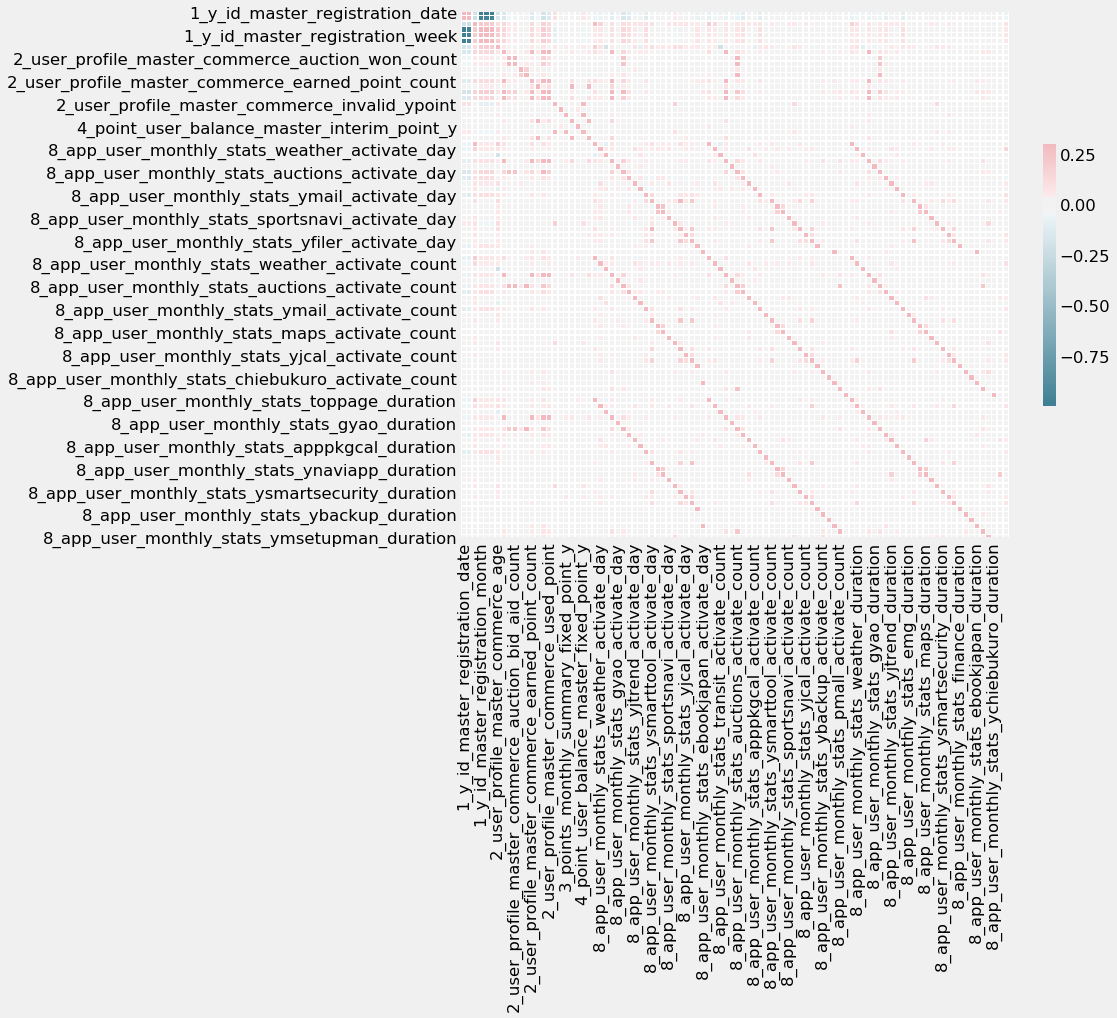

In [16]:
vd = DenseVisualizer(train=train, test=test, features=dense_features, target=target)
vd.correlation_matrix()

# Categorical features

In [17]:
# EDA for categorical features
vc = CategoricalVisualizer(train=train, test=test, features=cat_features, target=target)
chkc = vc.column_checker()

feature name = y_id_hex
feature name = 1_y_id_master_gender
feature name = 1_y_id_master_birthday
feature name = 2_user_profile_master_commerce_gender
feature name = 2_user_profile_master_commerce_generation1
feature name = 2_user_profile_master_commerce_generation3
feature name = 2_user_profile_master_commerce_generation5
feature name = 2_user_profile_master_commerce_tcard_status
feature name = 2_user_profile_master_commerce_premium_user_flag
feature name = 2_user_profile_master_commerce_premium_segment_id
feature name = 2_user_profile_master_commerce_wallet_registered_flag
feature name = 2_user_profile_master_commerce_valid_card_count
feature name = 2_user_profile_master_commerce_auction_store_flag
feature name = 5_tcard_status_master_tcard_status
feature name = 6_point_user_monthly_stats_point_type
feature name = 6_point_user_monthly_stats_earned_limited_point
feature name = 6_point_user_monthly_stats_used_point_count
feature name = 6_point_user_monthly_stats_invalid_ypoint
feature 

feature name = 8_app_user_monthly_stats_ychiebukuro_activate_day
feature name = 8_app_user_monthly_stats_ybuzzdetection_activate_day
feature name = 8_app_user_monthly_stats_com_cf_selene_activate_day
feature name = 8_app_user_monthly_stats_realestate_activate_day
feature name = 8_app_user_monthly_stats_minkara_activate_day
feature name = 8_app_user_monthly_stats_com_cf_calendar_activate_day
feature name = 8_app_user_monthly_stats_com_cf_coletto_activate_day
feature name = 8_app_user_monthly_stats_v_assist_activate_day
feature name = 8_app_user_monthly_stats_yfinkeyguardwidget_activate_day
feature name = 8_app_user_monthly_stats_partner_activate_day
feature name = 8_app_user_monthly_stats_com_cfinc_calendar_activate_day
feature name = 8_app_user_monthly_stats_jp_trilltrill_trill_activate_day
feature name = 8_app_user_monthly_stats_yphoto_activate_day
feature name = 8_app_user_monthly_stats_appcover_launcher2_activate_day
feature name = 8_app_user_monthly_stats_com_cfinc_coletto_activate

feature name = 8_app_user_monthly_stats_yjcal_widget_activate_day
feature name = 8_app_user_monthly_stats_yfiler_widget_activate_day
feature name = 8_app_user_monthly_stats_apps_map_widget_activate_day
feature name = 8_app_user_monthly_stats_apps_navi_widget_activate_day
feature name = 8_app_user_monthly_stats_finance_widget_activate_day
feature name = 8_app_user_monthly_stats_ybackup_widget_activate_day
feature name = 8_app_user_monthly_stats_chiebukuro_widget_activate_day
feature name = 8_app_user_monthly_stats_yqrcode_widget_activate_day
feature name = 8_app_user_monthly_stats_launcher_buzzhome_widget_activate_day
feature name = 8_app_user_monthly_stats_ebookjapan_widget_activate_day
feature name = 8_app_user_monthly_stats_pmall_widget_activate_day
feature name = 8_app_user_monthly_stats_ymsetupman_widget_activate_day
feature name = 8_app_user_monthly_stats_realtime_buzzalert_widget_activate_day
feature name = 8_app_user_monthly_stats_ychiebukuro_widget_activate_day
feature name = 8

In [18]:
chkc.style.background_gradient()

In [19]:
# remove features with too many nans
cat_features = chkc.loc[chkc["train_nans"] < 3000, "features"].values.tolist()
print(cat_features)

['y_id_hex', '1_y_id_master_gender', '2_user_profile_master_commerce_gender', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_premium_user_flag', '2_user_profile_master_commerce_wallet_registered_flag', '2_user_profile_master_commerce_valid_card_count', '2_user_profile_master_commerce_auction_store_flag', '8_app_user_monthly_stats_toppage_flag', '8_app_user_monthly_stats_weather_flag', '8_app_user_monthly_stats_transit_flag', '8_app_user_monthly_stats_shopping_flag', '8_app_user_monthly_stats_gyao_flag', '8_app_user_monthly_stats_auctions_flag', '8_app_user_monthly_stats_mail_flag', '8_app_user_monthly_stats_yjtrend_flag', '8_app_user_monthly_stats_apppkgcal_flag', '8_app_user_monthly_stats_ymail_flag', '8_app_user_monthly_stats_emg_flag', '8_app_user_monthly_stats_ysmarttool_flag', '8_app_user_monthly_stats_ybrowser_flag', '8_app_user_monthly_stats_ynaviapp_flag', 

In [20]:
catv = CategoricalVisualizer(train, test, ['2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3'], target)

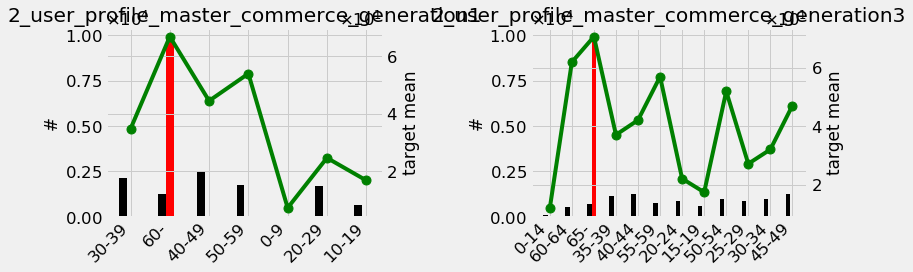

In [21]:
catv.plot_bars()

In [22]:
test['2_user_profile_master_commerce_generation1'].value_counts()

60-      9895
10-19      41
20-29      21
30-39      18
40-49      14
50-59      11
Name: 2_user_profile_master_commerce_generation1, dtype: int64

# Fit LGB and Get Feature importance

In [23]:
for f in features:
    if train[f].dtype == "bool":
        train[f] = train[f].astype(int)
        test[f] = test[f].astype(int)
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

In [24]:
# label encoding object features
train, test = label_encoding(train, test, cat_features)
train.head()

,y_id_hex,1_y_id_master_gender,1_y_id_master_birthday,1_y_id_master_registration_date,1_y_id_master_first_update,1_y_id_master_last_update,1_y_id_master_age,1_y_id_master_registration_month,1_y_id_master_registration_week,2_user_profile_master_commerce_registration_month,...,99_yup_user_daily_score_2_interest_know_well_world_history,99_yup_user_daily_score_2_interest_know_well_art,99_yup_user_daily_score_2_interest_know_well_iphone,99_yup_user_daily_score_2_interest_know_well_android,99_yup_user_daily_score_2_interest_know_well_pc,99_yup_user_daily_score_2_interest_know_well_home_appliance,99_yup_user_daily_score_2_interest_starting_own_business,99_yup_user_daily_score_2_interest_know_well_stock_economy,99_yup_user_daily_score_2_interest_know_well_internet_setup,99_yup_user_daily_score_2_interest_know_well_construction
0,1913,1,NaN,20190428,20190501.0,20191201,49,8,31,8,...,NaN,0.067452,NaN,NaN,NaN,NaN,0.05795,NaN,NaN,NaN
1,2060,1,NaN,20160925,20160929.0,20191127,45,39,166,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,465,1,NaN,20160508,20160513.0,20191130,23,43,186,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1361,1,NaN,20160612,20160615.0,20191201,42,42,181,42,...,NaN,0.035689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1366,1,NaN,20191020,20191022.0,20191201,58,2,6,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
train[target].isna().sum()

0

In [26]:
test[target].isna().sum()

10000

In [27]:
features = dense_features + cat_features
target in features

False

In [28]:
test[['2_user_profile_master_commerce_age', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3']].head()

,2_user_profile_master_commerce_age,2_user_profile_master_commerce_generation1,2_user_profile_master_commerce_generation3
0,NaN,6,11
1,NaN,6,11
2,NaN,6,11
3,NaN,6,11
4,NaN,6,11


In [29]:
# drop leak features
dropcols = ['2_user_profile_master_commerce_age', '2_user_profile_master_commerce_generation1', '2_user_profile_master_commerce_generation3', '2_user_profile_master_commerce_generation5', '2_user_profile_master_commerce_generation7']
features = [f for f in features if f not in dropcols]
cat_features = [f for f in cat_features if f not in dropcols]

In [30]:
print(len(features))
features

349


['1_y_id_master_registration_date',
 '1_y_id_master_first_update',
 '1_y_id_master_last_update',
 '1_y_id_master_registration_month',
 '1_y_id_master_registration_week',
 '2_user_profile_master_commerce_registration_month',
 '2_user_profile_master_commerce_shopping_order_count',
 '2_user_profile_master_commerce_auction_won_count',
 '2_user_profile_master_commerce_auction_bid_aid_count',
 '2_user_profile_master_commerce_auction_submit_count',
 '2_user_profile_master_commerce_auction_sold_count',
 '2_user_profile_master_commerce_earned_point_count',
 '2_user_profile_master_commerce_monthly_fixed_point',
 '2_user_profile_master_commerce_used_point_count',
 '2_user_profile_master_commerce_used_point',
 '2_user_profile_master_commerce_invalid_ypoint',
 '3_points_monthly_summary_interim_point_y',
 '3_points_monthly_summary_fixed_point_y',
 '3_points_monthly_summary_fixed_point_t',
 '4_point_user_balance_master_interim_point_y',
 '4_point_user_balance_master_fixed_point_y',
 '4_point_user_bal

In [31]:
# fit LGB
lgbm = LgbModel(train, test, target, features, categoricals=cat_features, task="regression",
                  group="y_id_hex", cv_method="GroupKFold")

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 11.2304	valid_1's rmse: 13.1973
[200]	training's rmse: 10.1155	valid_1's rmse: 13.2674
Early stopping, best iteration is:
[108]	training's rmse: 11.1207	valid_1's rmse: 13.1961
Partial score of fold 0 is: 13.196117086346895
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 11.2507	valid_1's rmse: 13.1019
[200]	training's rmse: 10.1066	valid_1's rmse: 13.1455
Early stopping, best iteration is:
[111]	training's rmse: 11.1178	valid_1's rmse: 13.0895
Partial score of fold 1 is: 13.089506662927203
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 11.2632	valid_1's rmse: 12.9722
[200]	training's rmse: 10.1506	valid_1's rmse: 13.0346
Early stopping, best iteration is:
[114]	training's rmse: 11.0841	valid_1's rmse: 12.9611
Partial score of fold 2 is: 12.961148150125382
Our oof loss score is:  13.082621386805693


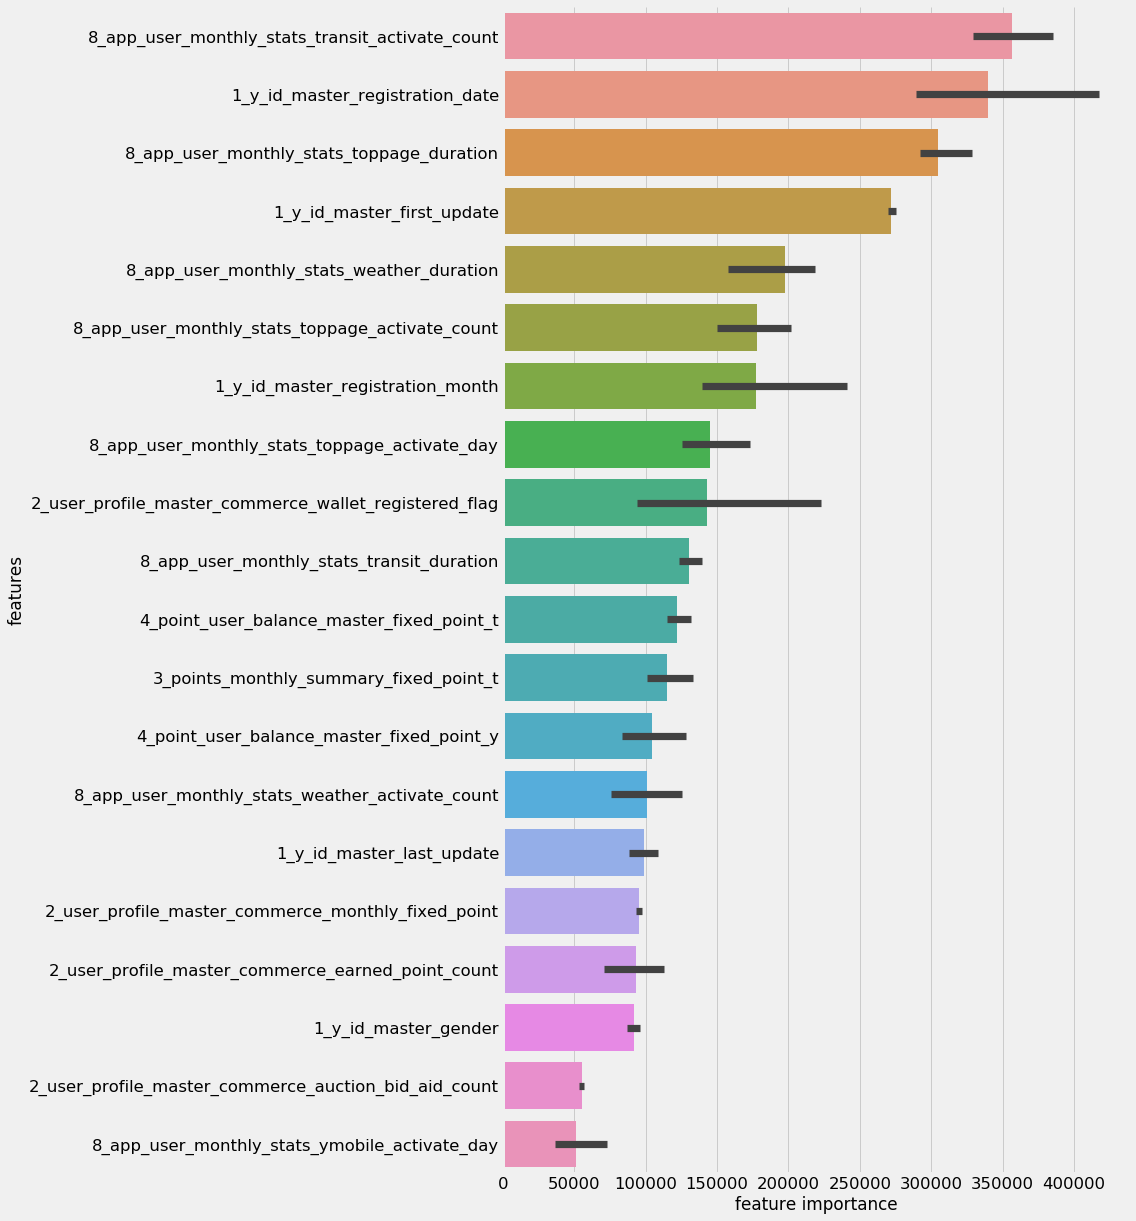

In [32]:
# plot feature importance
lgbm_fi_df = lgbm.plot_feature_importance(rank_range=[1,20])

In [33]:
test["1_y_id_master_registration_date"].head()

0    20170528
1    20190224
2    20190623
3    20190616
4    20190922
Name: 1_y_id_master_registration_date, dtype: int64

 # Adversarial validation

In [34]:
dropcols = dropcols + ["1_y_id_master_gender", "2_user_profile_master_commerce_gender"]
features = [f for f in features if f not in dropcols]
cat_features = [f for f in cat_features if f not in dropcols]

In [35]:
# fit LGB
adval = AdversarialValidation(train, test, features, categoricals=cat_features, group="y_id_hex")

In [36]:
adval_model = adval.run()

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.979664	valid_1's auc: 0.962335
Early stopping, best iteration is:
[90]	training's auc: 0.978407	valid_1's auc: 0.962529
Partial score of fold 0 is: 0.9625286684770626
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.979427	valid_1's auc: 0.966099
[200]	training's auc: 0.987152	valid_1's auc: 0.964951
Early stopping, best iteration is:
[105]	training's auc: 0.980003	valid_1's auc: 0.966268
Partial score of fold 1 is: 0.9662684805256684
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.979272	valid_1's auc: 0.966148
Early stopping, best iteration is:
[79]	training's auc: 0.976669	valid_1's auc: 0.966414
Partial score of fold 2 is: 0.9664138001133743
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.98058	valid_1's auc: 0.961963
[200]	training's auc: 0.987781	valid_1's auc: 0.961256
Early stopping

,index,features,importance,fold,importance_mean
0,1039,1_y_id_master_first_update,29286.449857,3,24366.094464
1,693,1_y_id_master_first_update,23893.963819,2,24366.094464
2,1,1_y_id_master_first_update,23079.679736,0,24366.094464
3,347,1_y_id_master_first_update,21204.284443,1,24366.094464
4,0,1_y_id_master_registration_date,11739.258647,0,10178.238998
5,346,1_y_id_master_registration_date,11538.853396,1,10178.238998
6,1038,1_y_id_master_registration_date,6695.712130,3,10178.238998
7,692,1_y_id_master_registration_date,10739.131817,2,10178.238998
8,1053,2_user_profile_master_commerce_invalid_ypoint,6104.990046,3,6138.545429
9,707,2_user_profile_master_commerce_invalid_ypoint,6196.685558,2,6138.545429


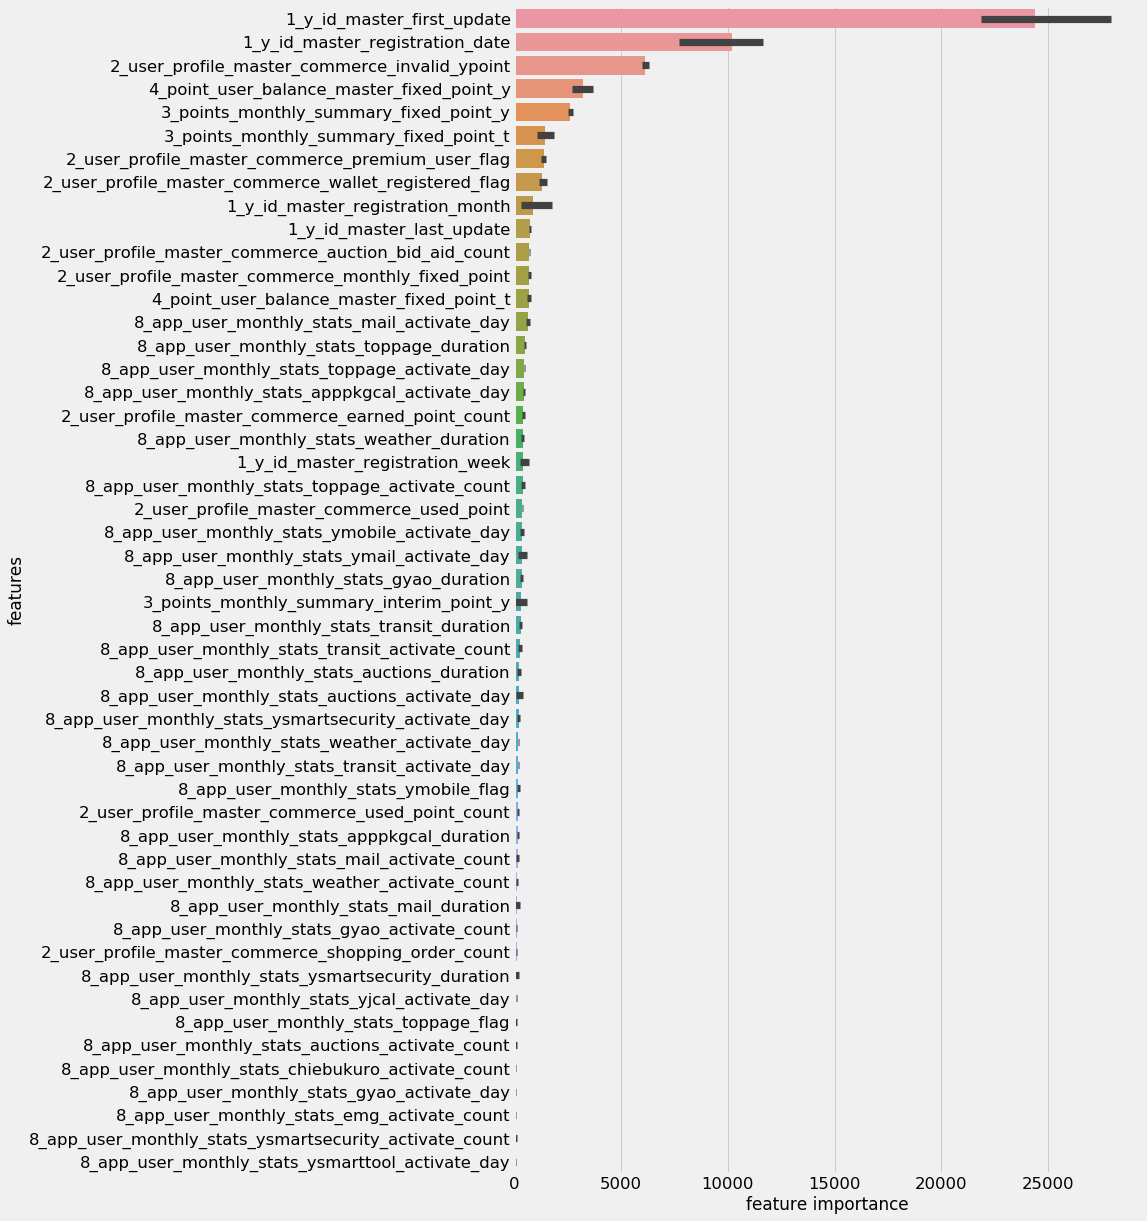

In [37]:
adval_model.plot_feature_importance()

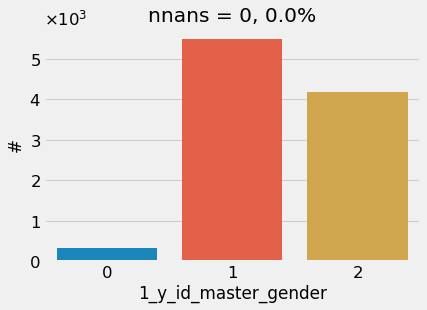

In [38]:
plot_target(train, "1_y_id_master_gender", objective="classification")

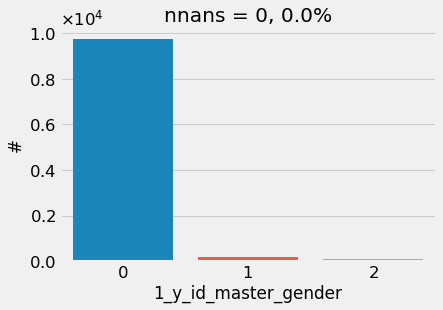

In [39]:
plot_target(test, "1_y_id_master_gender", objective="classification")